In [1]:
import numpy as np
from math import ceil
import os
import matplotlib.pyplot as plt
import pandas as pd

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread_collection
from skimage.util import img_as_ubyte
from skimage import data

In [2]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 81kB/s 


In [3]:
import pydicom as dicom

In [4]:
#INTERPOLATION FUNCTION
def interpolate(subBin,LU,RU,LB,RB,subX,subY):
    subImage = np.zeros(subBin.shape)
    num = subX*subY
    for i in range(subX):
        inverseI = subX-i
        for j in range(subY):
            inverseJ = subY-j
            val = subBin[i,j].astype(int)
            subImage[i,j] = np.floor((inverseI*(inverseJ*LU[val] + j*RU[val])+ i*(inverseJ*LB[val] + j*RB[val]))/float(num))
    return subImage


CLAHE contrast equa;ization method.
clipLimit - Normalized clipLimit. Higher value gives more contrast
img - Input image, 

nrBins - Number of graylevel bins for histogram("dynamic range")

nrX - Number of contextial regions in X direction

nrY - Number of Contextial regions in Y direction

In [5]:
def clahe(img,clipLimit,nrBins=32,nrX=0,nrY=0):

    h,w = img.shape
    if clipLimit==1:
        return
    nrBins = max(nrBins,32)
    if nrX==0:
        #Taking dimensions of each contextial region to be a square of 32X32
        xsz = 32
        ysz = 32
        nrX = ceil(h/xsz)#240
        #Excess number of pixels to get an integer value of nrX and nrY
        excX= int(xsz*(nrX-h/xsz))
        nrY = ceil(w/ysz)#320
        excY= int(ysz*(nrY-w/ysz))
        #Pad that number of pixels to the image
        if excX!=0:
            img = np.append(img,np.zeros((excX,img.shape[1])).astype(int),axis=0)
        if excY!=0:
            img = np.append(img,np.zeros((img.shape[0],excY)).astype(int),axis=1)
    else:
        xsz = round(h/nrX)
        ysz = round(w/nrY)
    
    nrPixels = xsz*ysz
    xsz2 = round(xsz/2)
    ysz2 = round(ysz/2)
    claheimg = np.zeros(img.shape)
    
    if clipLimit > 0:
        clipLimit = max(1,clipLimit*xsz*ysz/nrBins)
    else:
        clipLimit = 50
    
    print("...Make the LUT...")
    minVal = 0 
    maxVal = 255 
    
    binSz = np.floor(1+(maxVal-minVal)/float(nrBins))
    LUT = np.floor((np.arange(minVal,maxVal+1)-minVal)/float(binSz))
    
    #BACK TO CLAHE
    bins = LUT[img]
    print(bins.shape)

    print("...Making the Histogram...")
    hist = np.zeros((nrX,nrY,nrBins))
    print(nrX,nrY,hist.shape)
    for i in range(nrX):
        for j in range(nrY):
            bin_ = bins[i*xsz:(i+1)*xsz,j*ysz:(j+1)*ysz].astype(int)
            for i1 in range(xsz):
                for j1 in range(ysz):
                    hist[i,j,bin_[i1,j1]]+=1
    
    print("...Clipping the Histogram...")
    if clipLimit>0:
        for i in range(nrX):
            for j in range(nrY):
                nrExcess = 0
                for nr in range(nrBins):
                    excess = hist[i,j,nr] - clipLimit
                    if excess>0:
                        nrExcess += excess
                
                binIncr = nrExcess/nrBins
                upper = clipLimit - binIncr
                for nr in range(nrBins):
                    if hist[i,j,nr] > clipLimit:
                        hist[i,j,nr] = clipLimit
                    else:
                        if hist[i,j,nr]>upper:
                            nrExcess += upper - hist[i,j,nr]
                            hist[i,j,nr] = clipLimit
                        else:
                            nrExcess -= binIncr
                            hist[i,j,nr] += binIncr
                
                if nrExcess > 0:
                    stepSz = max(1,np.floor(1+nrExcess/nrBins))
                    for nr in range(nrBins):
                        nrExcess -= stepSz
                        hist[i,j,nr] += stepSz
                        if nrExcess < 1:
                            break
    
    #mapHistogram
    print("...Mapping the Histogram...")
    map_ = np.zeros((nrX,nrY,nrBins))
    #print(map_.shape)
    scale = (maxVal - minVal)/float(nrPixels)
    for i in range(nrX):
        for j in range(nrY):
            sum_ = 0
            for nr in range(nrBins):
                sum_ += hist[i,j,nr]
                map_[i,j,nr] = np.floor(min(minVal+sum_*scale,maxVal))
    
    #BACK TO CLAHE
    #INTERPOLATION
    print("...interpolation...")
    xI = 0
    for i in range(nrX+1):
        if i==0:
            subX = int(xsz/2)
            xU = 0
            xB = 0
        elif i==nrX:
            subX = int(xsz/2)
            xU = nrX-1
            xB = nrX-1
        else:
            subX = xsz
            xU = i-1
            xB = i
        
        yI = 0
        for j in range(nrY+1):
            if j==0:
                subY = int(ysz/2)
                yL = 0
                yR = 0
            elif j==nrY:
                subY = int(ysz/2)
                yL = nrY-1
                yR = nrY-1
            else:
                subY = ysz
                yL = j-1
                yR = j
            UL = map_[xU,yL,:]
            UR = map_[xU,yR,:]
            BL = map_[xB,yL,:]
            BR = map_[xB,yR,:]
            #print("CLAHE vals...")
            subBin = bins[xI:xI+subX,yI:yI+subY]
            #print("clahe subBin shape: ",subBin.shape)
            subImage = interpolate(subBin,UL,UR,BL,BR,subX,subY)
            claheimg[xI:xI+subX,yI:yI+subY] = subImage
            yI += subY
        xI += subX
    
    if excX==0 and excY!=0:
        return claheimg[:,:-excY]
    elif excX!=0 and excY==0:
        return claheimg[:-excX,:]
    elif excX!=0 and excY!=0:
        return claheimg[:-excX,:-excY]
    else:
        return claheimg

In [6]:
#os.mkdir('/content/drive/My Drive/Datasets/intern/')
#os.mkdir('/content/drive/My Drive/Datasets/intern/Inbreast/')
#os.mkdir('/content/drive/My Drive/Datasets/intern/Inbreast/clahe_1/')
#os.mkdir('/content/drive/My Drive/Datasets/project_2020/INbreast Release 1.0/Alljpgs')


In [ ]:
#your path 
#col_dir = '/content/drive/My Drive/Datasets/project_2020/all-mias/*.pgm'
img_dir = '/content/drive/My Drive/Datasets/project_2020/INbreast Release 1.0/AllDICOMs'
#out_dir = '/content/drive/My Drive/Datasets/intern/Inbreast/clahe_1/'
#dir='/content/drive/My Drive/Datasets/project_2020/INbreast Release 1.0/Alljpgs'
#creating a collection with the available images
#col = imread_collection(col_dir)

In [ ]:
'''def dicom_to_jpg(folder,out_folder):
  for filename in os.listdir(folder):
    if filename.endswith(".dcm"):
        ds = dicom.dcmread((os.path.join(folder,filename)))
        data1 = ds.pixel_array
        filename = filename.replace('.dcm', '.jpg' )
        io.imsave(os.path.join(out_folder,filename), data1)'''

'def dicom_to_jpg(folder,out_folder):\n  for filename in os.listdir(folder):\n    if filename.endswith(".dcm"):\n        ds = dicom.dcmread((os.path.join(folder,filename)))\n        data1 = ds.pixel_array\n        filename = filename.replace(\'.dcm\', \'.jpg\' )\n        io.imsave(os.path.join(out_folder,filename), data1)'

In [ ]:
#dicom_to_jpg(img_dir,dir)

SCDA applied for Inbreast dataset


In [ ]:
def preprocess(folder,scaling_factor,clip_limit,out_folder,string):
  images = []
  cropped_images = []
  clahe_images = []
  count=0

#   for img in image_collection:
#  for filename in os.listdir(folder):
  for filename in os.listdir(folder):
    filename12 = filename.replace('.dcm', '.jpg' )
    filename1=string+filename12
    if filename1 not in os.listdir(out_folder):
    #if filename not in [i for i in os.listdir(out_folder)]:  
      if filename.endswith(".pgm"):
        count=count+1
        print(".....",count)
        img = io.imread(os.path.join(folder,filename))
        print("read")
        image_rescaled = rescale(img, scaling_factor, anti_aliasing=False)
        print("scaled")

        clahe_img = clahe(image_rescaled,clip_limit,0,0)
        print("contrast enhanced")

        x1=(clahe_img.shape[0]//2)-512
        x2=(clahe_img.shape[0]//2)+512
        y1=(clahe_img.shape[0]//2)-512
        y2=(clahe_img.shape[0]//2)+512

        temp=clahe_img[x1:x2,y1:y2]
        print("cropped")

        cropped=img_as_ubyte(temp)

        io.imsave(out_folder+"/"+string+filename, cropped)

        if img is not None:
            images.append(img)
        if cropped is not None:
            cropped_images.append(cropped)
        if clahe_img is not None:
            clahe_images.append(clahe_img)

      elif filename.endswith(".dcm"):
        count=count+1
        print(".....",count)
        ds = dicom.dcmread((os.path.join(folder,filename)))
        img = ds.pixel_array
        
        print("read")
        resized_img = resize(img, (1024, 1024), anti_aliasing=True)
    
        image_rescaled = rescale(resized_img, scaling_factor, anti_aliasing=False)
        print("scaled")

        x1=(image_rescaled.shape[0]//2)-512
        x2=(image_rescaled.shape[0]//2)+512
        y1=(image_rescaled.shape[0]//2)-512
        y2=(image_rescaled.shape[0]//2)+512

        temp=image_rescaled[x1:x2,y1:y2]
        print("cropped")

        cropped=img_as_ubyte(temp)

        clahe_img = clahe(cropped,clip_limit,0,0)
        print("contrast enhanced")
        #print(img)
        filename = filename.replace('.dcm', '.jpg' )

        io.imsave(out_folder+"/"+string+filename , clahe_img)

        if img is not None:
            images.append(img)
        if cropped is not None:
            cropped_images.append(cropped)
        if clahe_img is not None:
            clahe_images.append(clahe_img)

  return images,cropped_images,clahe_images

In [ ]:
imgs,cropped_imgs,clahe_imgs=preprocess(img_dir,1.25,3,"/content/drive/My Drive/intern_code/Images","clahe125_")

In [ ]:
imgs,cropped_imgs,clahe_imgs=preprocess(img_dir,1.75,3,"/content/drive/My Drive/intern_code/Images","clahe175_")

In [ ]:
imgs,cropped_imgs,clahe_imgs=preprocess(img_dir,1.5,3,"/content/drive/My Drive/intern_code/Images","clahe15_")

In [ ]:
imgs,cropped_imgs,clahe_imgs=preprocess('/content/drive/My Drive/Datasets/project_2020/all-mias',1.5,3,"/content/drive/My Drive/intern_code/Images","clahe15_")

In [ ]:
imgs,cropped_imgs,clahe_imgs=preprocess('/content/drive/My Drive/Datasets/project_2020/all-mias',1.25,3,"/content/drive/My Drive/intern_code/Images","clahe125_")

In [ ]:
imgs,cropped_imgs,clahe_imgs=preprocess('/content/drive/My Drive/Datasets/project_2020/all-mias',1.75,3,"/content/drive/My Drive/intern_code/Images","clahe175_")

In [ ]:
imgs,cropped_imgs,clahe_imgs=preprocess('/content/drive/My Drive/Datasets/project_2020/all-mias',1,3,"/content/drive/My Drive/intern_code/Images","clahe1_")

In [ ]:
imgs,cropped_imgs,clahe_imgs=preprocess(img_dir,1,3,"/content/drive/My Drive/intern_code/Images","clahe1_")

In [18]:
from pydicom.data import get_testdata_files

In [19]:
ds = dicom.dcmread("/content/drive/My Drive/Datasets/project_2020/INbreast Release 1.0/AllDICOMs/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm")
img = ds.pixel_array

In [20]:
img.shape

(4084, 3328)

In [ ]:
resized_img = resize(img, (1024, 1024), anti_aliasing=True)

resized_img.shape

In [ ]:
image_rescaled = rescale(resized_img,1.5, anti_aliasing=False)
print("scaled")

In [ ]:
image_rescaled.shape

In [ ]:
x1=(image_rescaled.shape[0]//2)-512
x2=(image_rescaled.shape[0]//2)+512
y1=(image_rescaled.shape[0]//2)-512
y2=(image_rescaled.shape[0]//2)+512

In [ ]:
temp=image_rescaled[x1:x2,y1:y2]
print("cropped")

cropped=img_as_ubyte(temp)

clahe_img = clahe(cropped,3,0,0)
print("contrast enhanced")

In [ ]:
plt.imshow(image_rescaled,cmap=plt.cm.bone)

In [ ]:
plt.imshow(cropped,cmap=plt.cm.bone)

In [ ]:
io.imsave('./1.png',clahe_img)

In [ ]:
        #print(img)
   filename = filename.replace('.dcm', '.jpg' )

        io.imsave(os.path.join(out_folder,filename), clahe_img)

        if img is not None:
            images.append(img)
        if cropped is not None:
            cropped_images.append(cropped)
        if clahe_img is not None:
            clahe_images.append(clahe_img)

In [ ]:
img = io.imread('/content/1.png')


Analysis and code testing

In [ ]:

#clipLimit = 3
#and setting xsz and ysz = 32

plt.imshow(img,cmap='gray')

In [ ]:
plt.imshow(clahe_img,cmap='gray')

In [ ]:
clahe_img.shape

...Make the LUT...
(1024, 1024)
...Making the Histogram...
32 32 (32, 32, 32)
...Clipping the Histogram...
...Mapping the Histogram...
...interpolation...


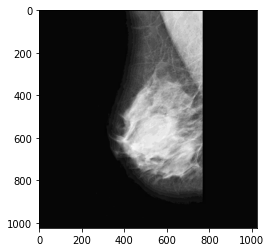

In [7]:
img = io.imread('/content/drive/My Drive/Datasets/project_2020/all-mias/mdb001.pgm')
clahe_img = clahe(img,2,0,0)
#clipLimit = 2
#and setting xsz and ysz = 32

plt.imshow(clahe_img,cmap='gray')

...Make the LUT...
(1024, 1024)
...Making the Histogram...
32 32 (32, 32, 32)
...Clipping the Histogram...
...Mapping the Histogram...
...interpolation...


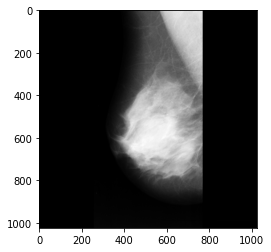

In [8]:
img = io.imread('/content/drive/My Drive/Datasets/project_2020/all-mias/mdb001.pgm')
clahe_img = clahe(img,3,0,0)
#clipLimit = 3
#and setting xsz and ysz = 16
plt.imshow(img,cmap='gray')

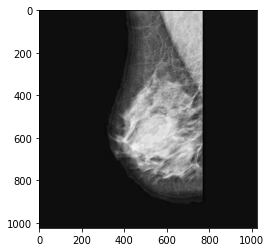

In [9]:
plt.imshow(clahe_img,cmap='gray')

(array([609613.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,  19732.]),
 array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
        0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
        0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
 <a list of 32 Patch objects>)

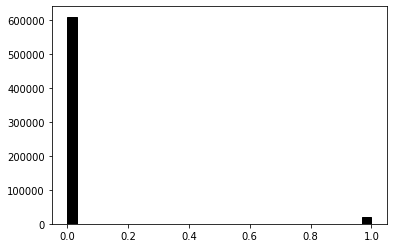

In [17]:
plt.hist(plt.imread('/content/drive/My Drive/Datasets/project_2020/all-mias/mdb001.pgm').ravel(), bins=32, range=(0.0, 1.0), fc='k', ec='k')

(array([2629.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 5938.]),
 array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
        0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
        0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
 <a list of 32 Patch objects>)

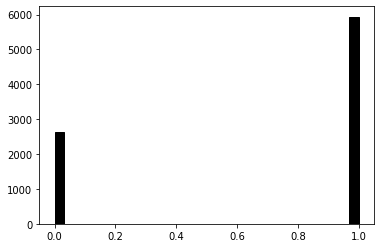

In [15]:
plt.hist(plt.imread('/content/drive/My Drive/intern_code/main_clahe_1/source/abnormal_clahe/mdb001.pgm').ravel(), bins=32, range=(0.0, 1.0), fc='k', ec='k')

In [ ]:
img = io.imread('/content/drive/My Drive/Datasets/project_2020/all-mias/mdb001.pgm')
clahe_img = clahe(img,3,0,0)
#clipLimit = 5
#and setting xsz and ysz = 64

plt.imshow(clahe_img,cmap='gray')

In [ ]:
img = io.imread('/content/drive/My Drive/Datasets/project_2020/all-mias/mdb001.pgm')
clahe_img = clahe(img,5,0,0)
#clipLimit = 5
#and setting xsz and ysz = 32

plt.imshow(clahe_img,cmap='gray')

In [ ]:
image_rescaled = rescale(img, 1.5, anti_aliasing=False)

In [ ]:
plt.imshow(image_rescaled,cmap='gray')

In [ ]:
image_rescaled.shape[0]/2-512

In [ ]:
1024/64

In [ ]:
cropped=image_rescaled[256:1280,256:1280]

In [ ]:
cropped.shape

In [ ]:
plt.imshow(cropped,cmap='gray')

In [ ]:
cropped

In [ ]:
c1=img_as_ubyte(cropped)

In [ ]:
clahe_img = clahe(c1,3,0,0)


In [ ]:
plt.imshow(clahe_img,cmap='gray')